# Latent representation analysis
In this notebook we analyse and compare the latent representations produced by the Wav2Vec2 feature extractor and the brain feature extractor

## Preperation

### Imports

In [1]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text_w_phonemes import Brain2TextWPhonemesDataset
from src.analysis.latent_analysis_util import generate_speech_multiple, generate_audio_representations, generate_brain_representations
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from src.args.yaml_config import YamlConfig
yaml_config = YamlConfig().config

### Extract test transcriptions

In [2]:
test_ds = Brain2TextWPhonemesDataset(B2TDatasetArgsModel(limit_samples=400), yaml_config, "test")
test_transcriptions = [test_ds[i].transcription for i in range(len(test_ds))]

### Generate speech for test transcriptions

In [3]:
generate_speech_multiple(test_transcriptions)

400/400 audios generated (0 newly generated)



## Generate audio latent representations

In [4]:
audio_representations = generate_audio_representations(test_ds)

Some weights of Wav2Vec2WithoutFeatExtrForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


400/400 audio representations generated 



## Generate brain latent representations

In [5]:
brain_representations = generate_brain_representations(test_ds)

/hpi/fs00/home/leon.hermann/mambaforge/envs/b2t/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of Wav2Vec2WithoutFeatExtrForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpi/fs00/home/leon.hermann/brain2text/src/model/b2p2t_model.py:90: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be crea

400/400 brain representations generated 



### Dim reduced brain representations

In [6]:
all_data = brain_representations.wav2vec_outputs + audio_representations.wav2vec_outputs #brain_representations.non_aggregated + audio_representations.non_aggregated
brain_data = brain_representations.wav2vec_outputs#brain_representations.non_aggregated
audio_data = audio_representations.wav2vec_outputs#audio_representations.non_aggregated

sample_idcs = [rep.idx for rep in all_data]
all_data_np = torch.stack([rep for _, rep in all_data]).numpy()
dim_reducer = TSNE(n_components=2)
all_data_dimreduced = dim_reducer.fit_transform(all_data_np)

In [7]:
sample_idcs = [rep.idx for rep in all_data]
unique_samples = set(sample_idcs)
sample_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_samples)))

### Clustering

In [15]:
from sklearn import cluster, mixture

from src.util.phoneme_helper import PHONE_DEF_SIL

phoneme_count = len(PHONE_DEF_SIL)
clustering_algo = mixture.GaussianMixture(n_components=phoneme_count)
cluster_colors = plt.cm.tab20(np.linspace(0, 1, phoneme_count))

brain_clusters = clustering_algo.fit_predict(all_data_np[:len(brain_data)])
audio_clusters = clustering_algo.fit_predict(all_data_np[len(brain_data):])

### Visualizing brain samples

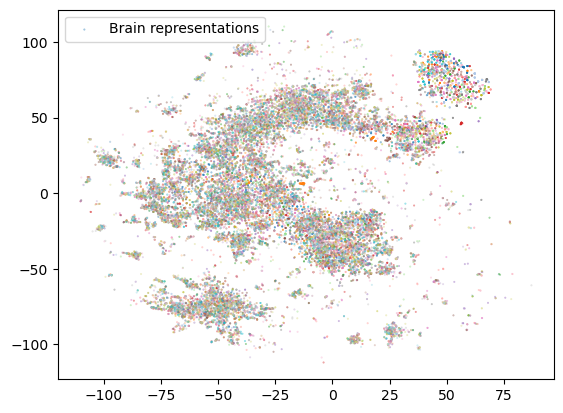

In [ ]:
plt.scatter(all_data_dimreduced[:len(brain_data), 0], all_data_dimreduced[:len(brain_data), 1], c=[sample_colors[sample.idx] for sample in all_data[:len(brain_data)]], label="Brain representations", alpha=0.5, s=0.2)
plt.legend()
plt.show()

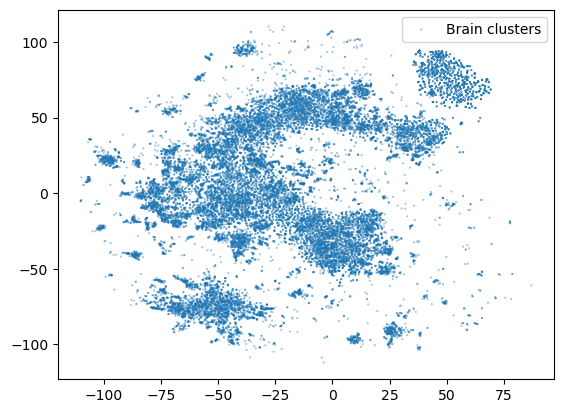

In [ ]:
plt.scatter(all_data_dimreduced[:len(brain_data), 0], all_data_dimreduced[:len(brain_data), 1], c=[cluster_colors[cluster] for cluster in brain_clusters], label="Brain clusters", alpha=0.5, s=0.2)
plt.legend()
plt.show()

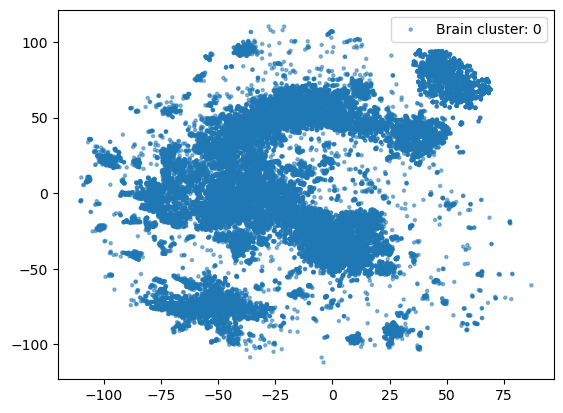

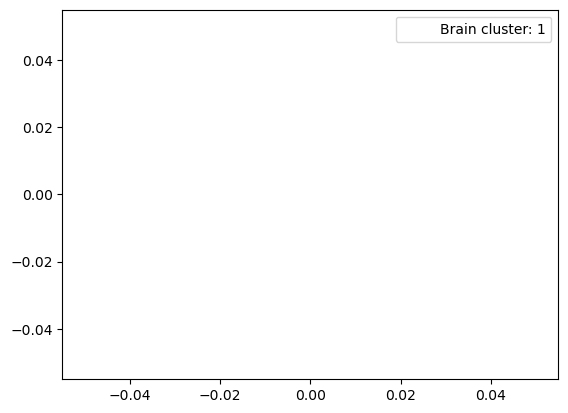

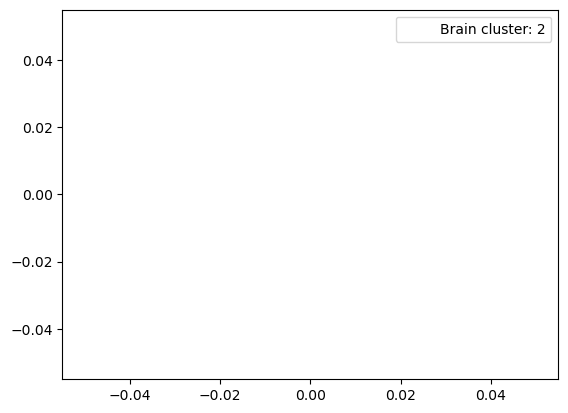

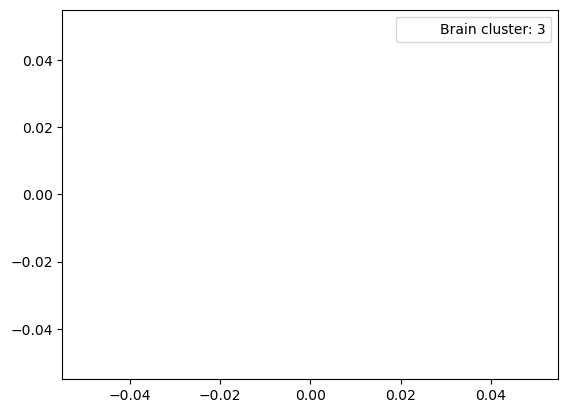

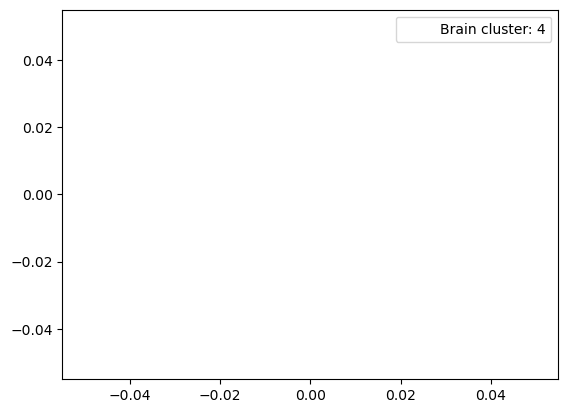

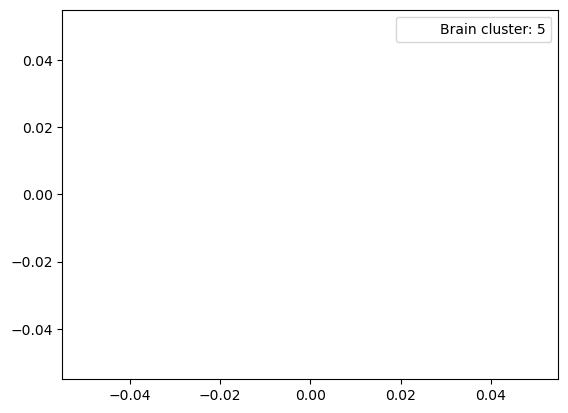

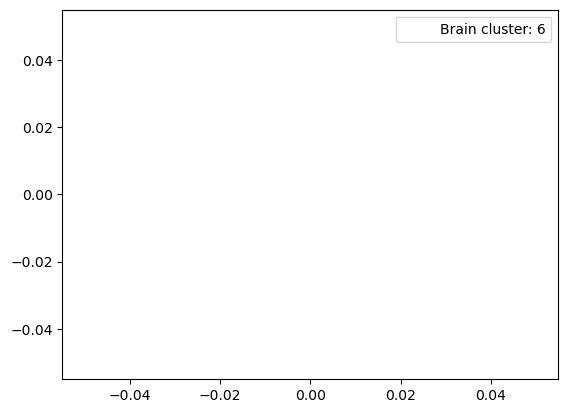

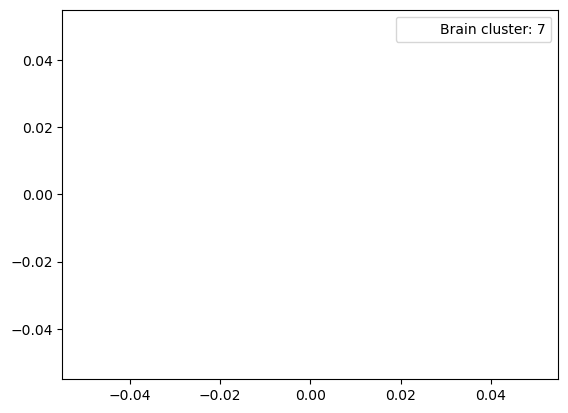

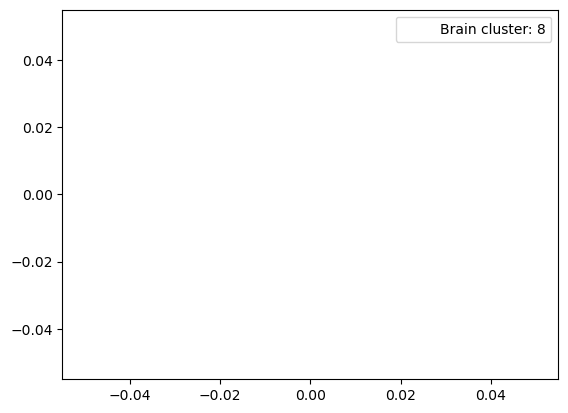

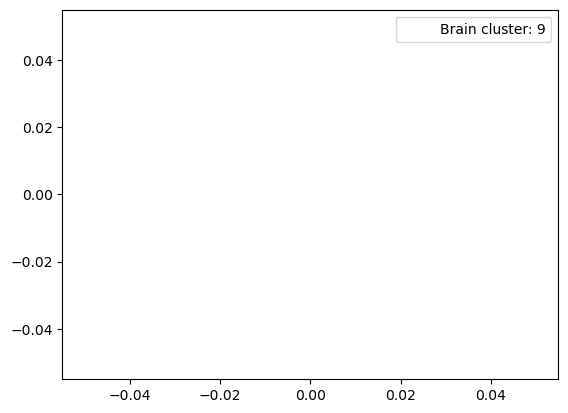

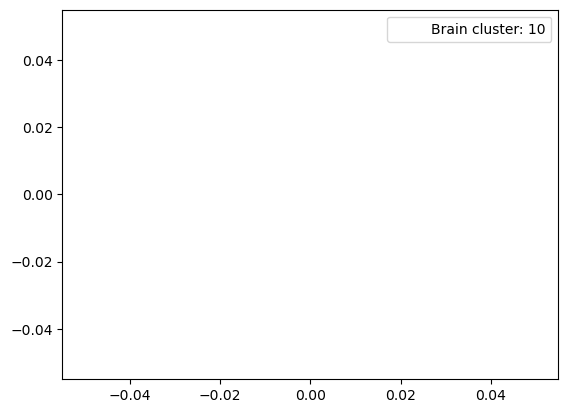

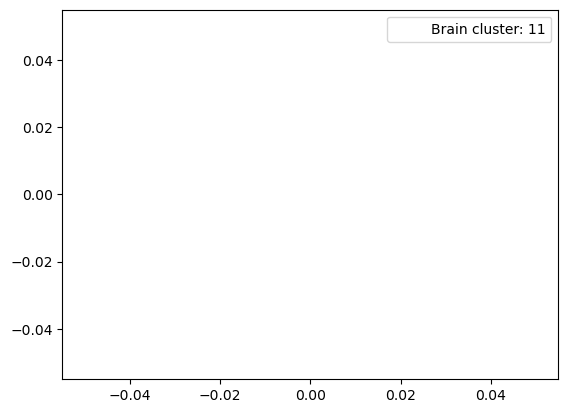

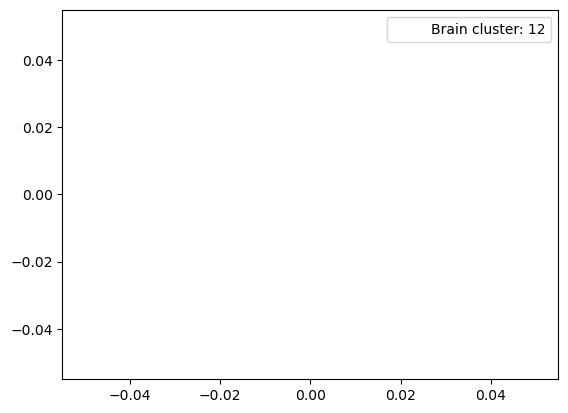

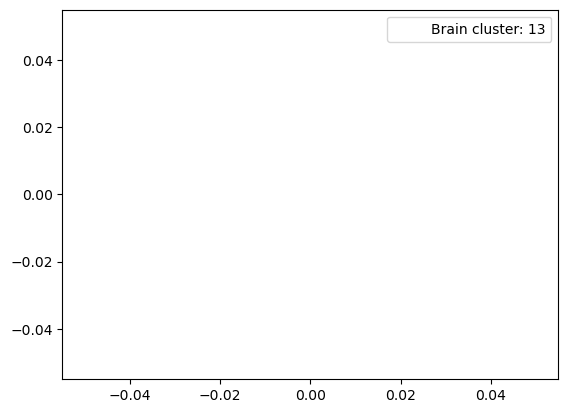

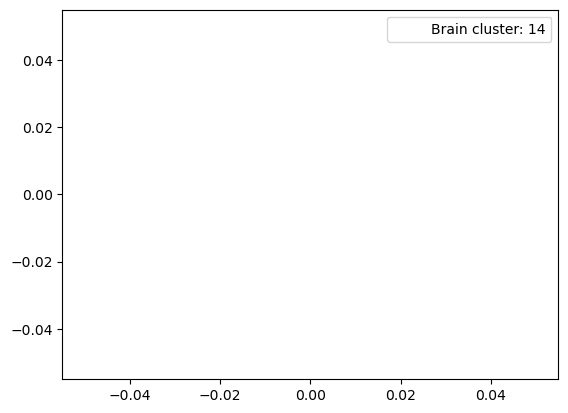

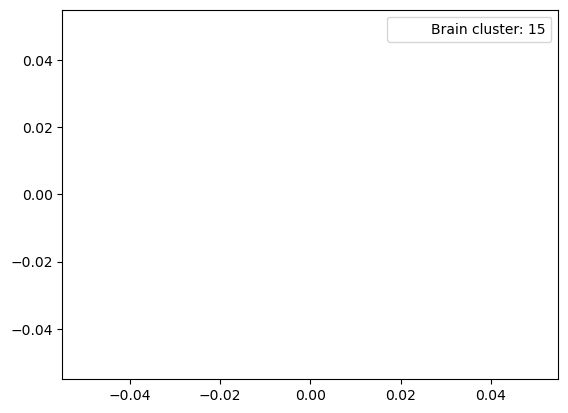

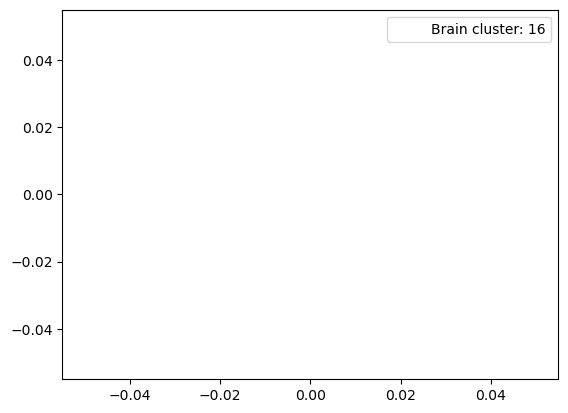

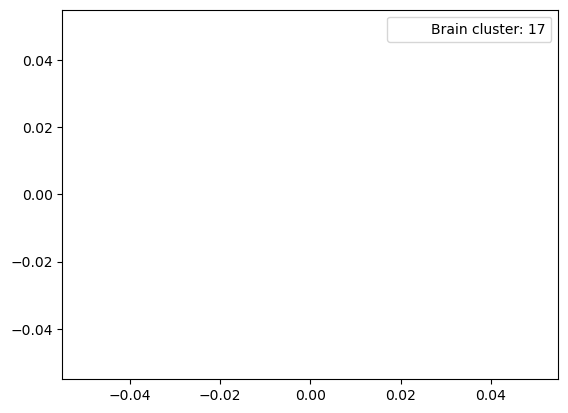

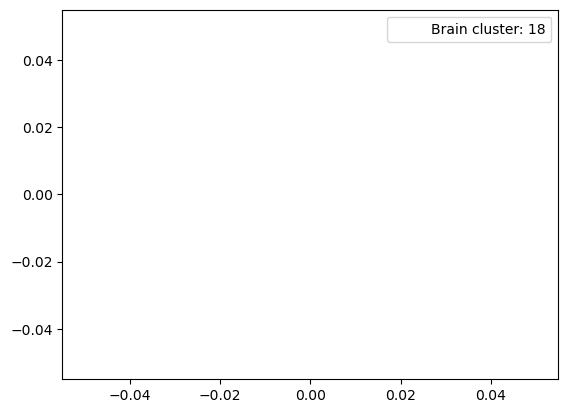

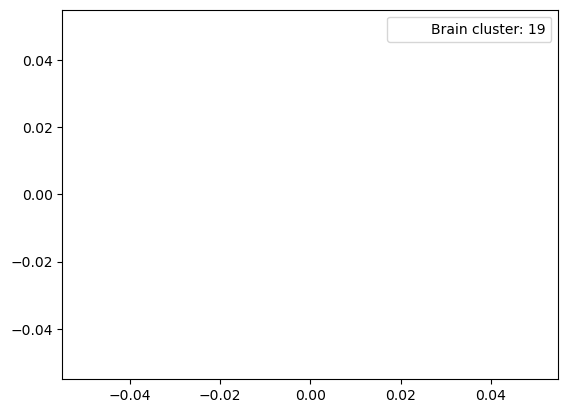

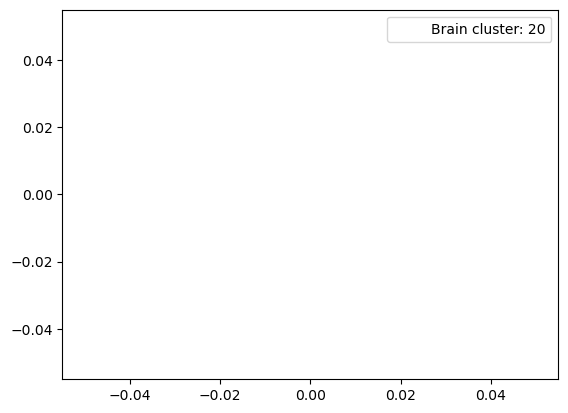

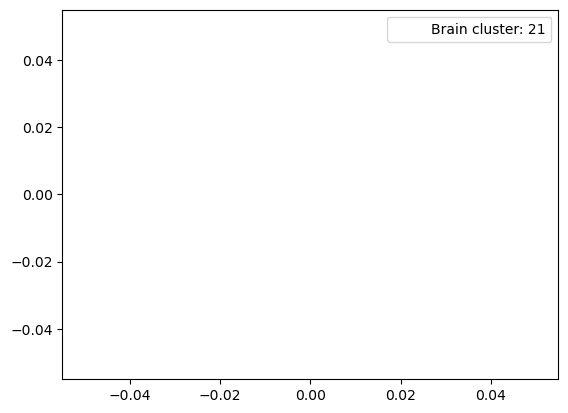

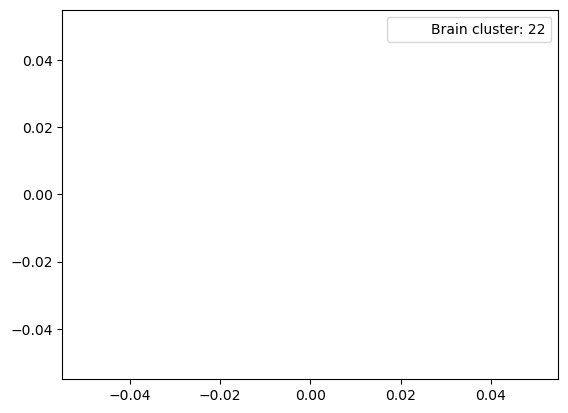

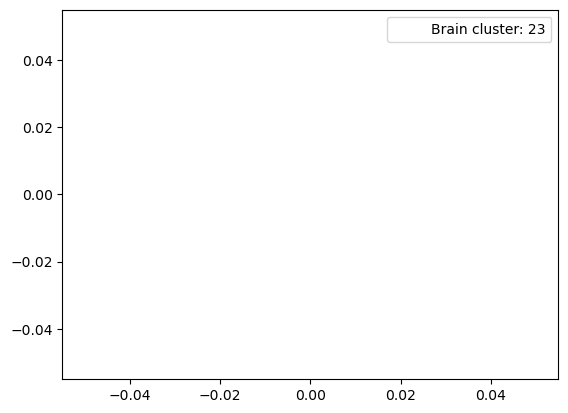

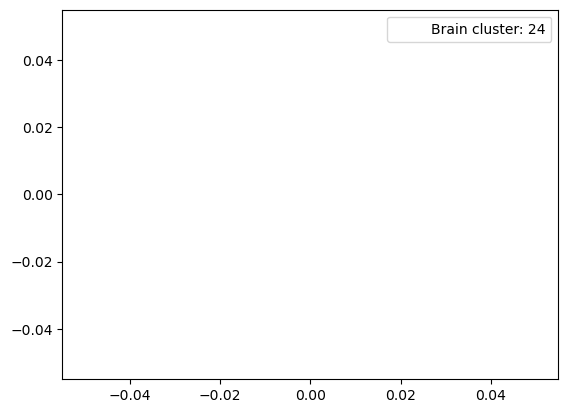

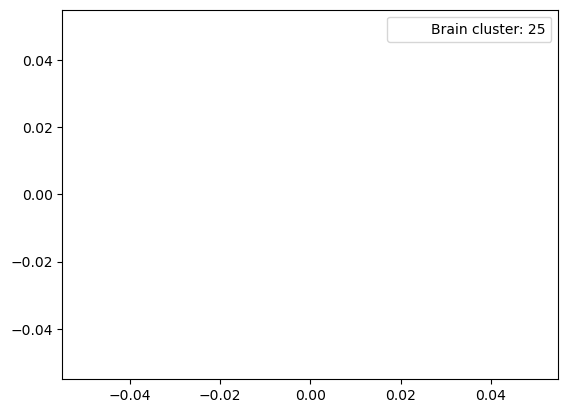

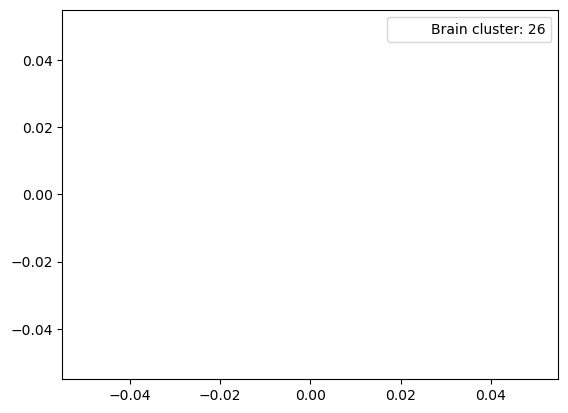

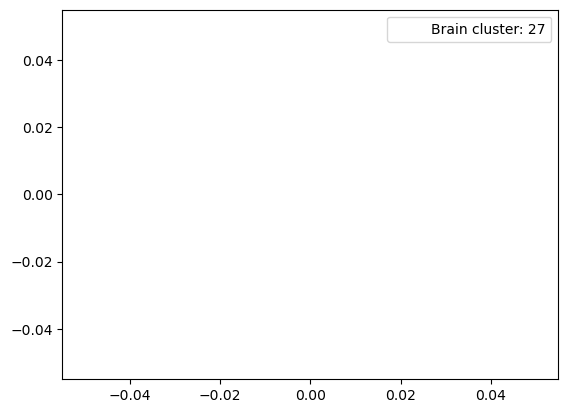

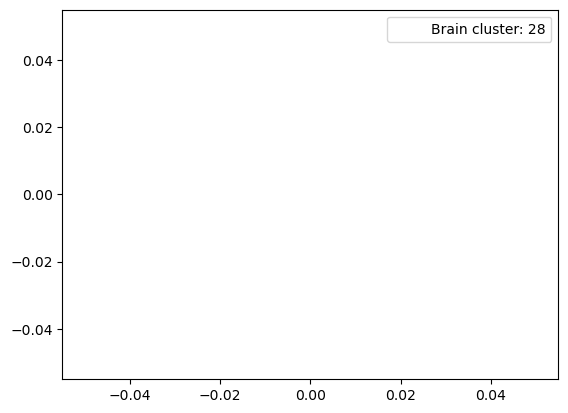

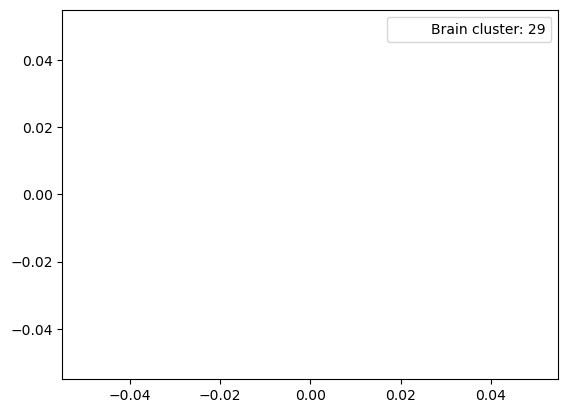

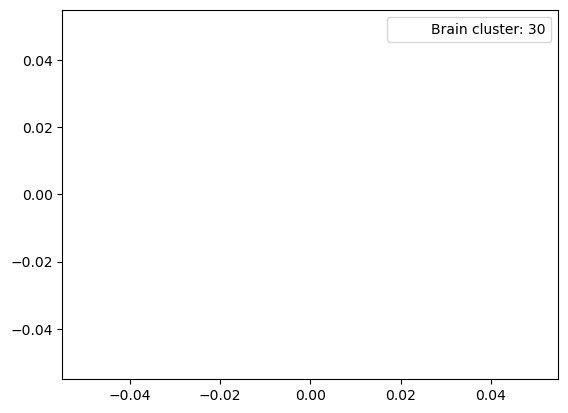

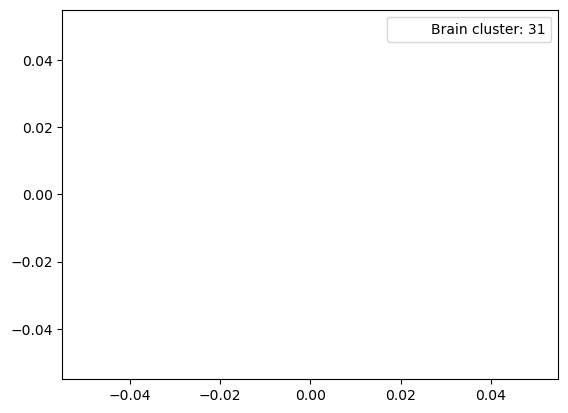

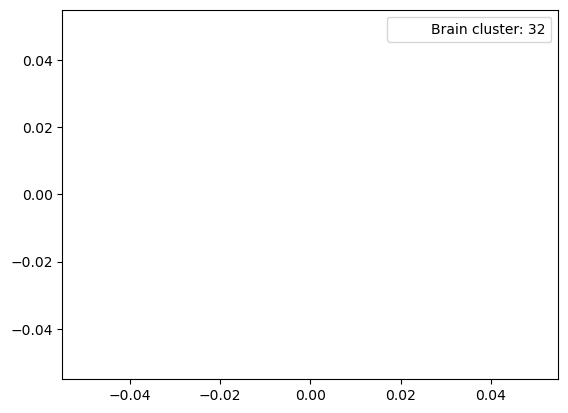

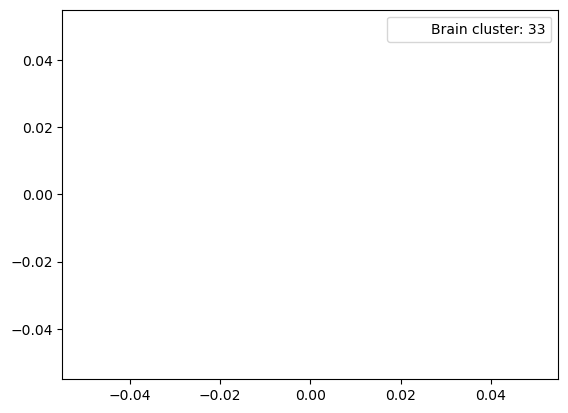

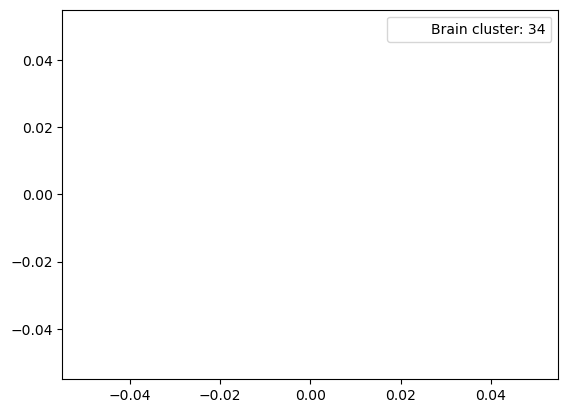

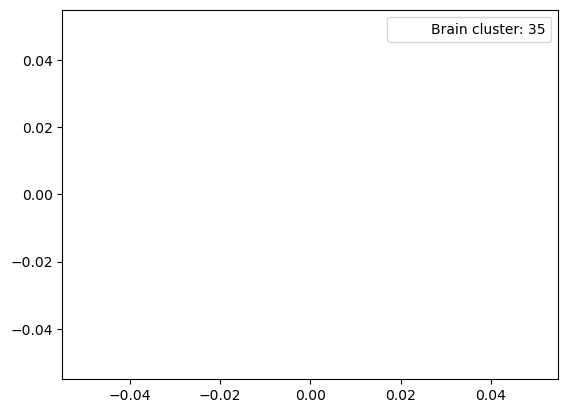

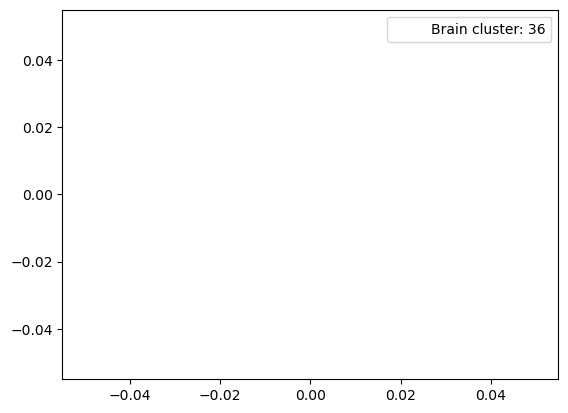

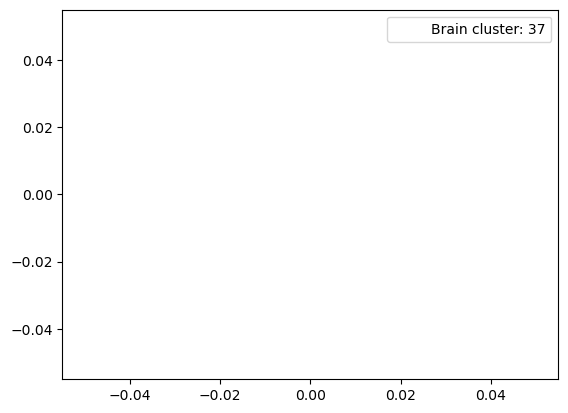

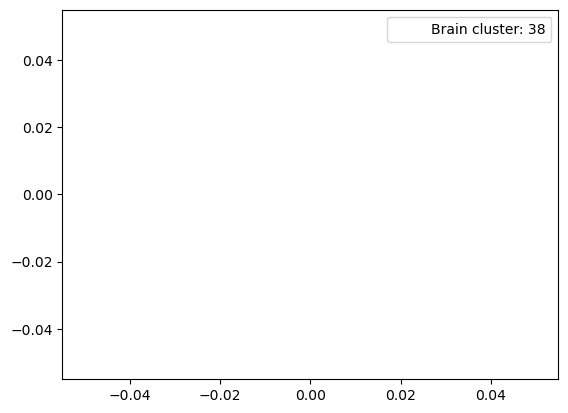

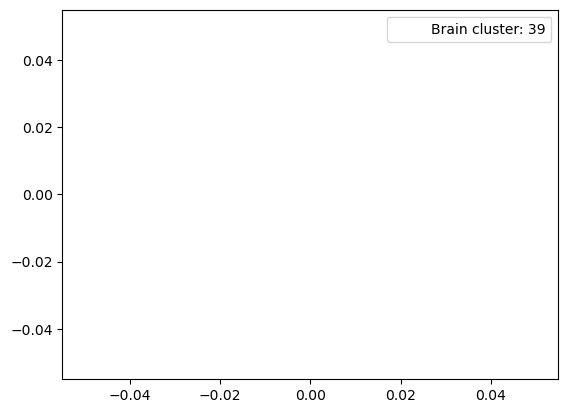

In [ ]:
for i in range(phoneme_count):
    idcs = [idx for idx, cluster in enumerate(brain_clusters) if cluster == i]
    samples = all_data_dimreduced[idcs]
    plt.scatter(samples[:, 0], samples[:, 1], c=[cluster_colors[i]] * len(samples), label=f"Brain cluster: {i}", alpha=0.5, s=5)
    plt.legend()
    plt.show()
    plt.close()

### Visualizing audio data

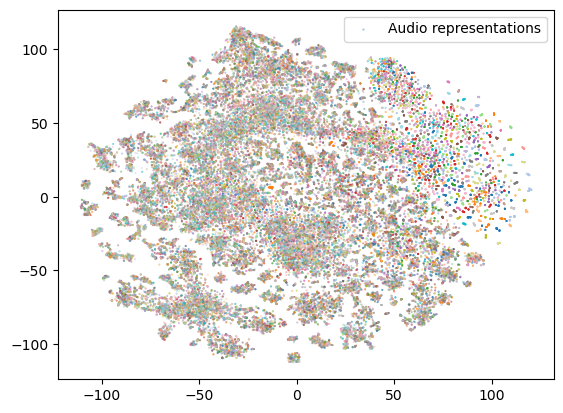

In [ ]:
plt.scatter(all_data_dimreduced[len(brain_representations.non_aggregated):, 0], all_data_dimreduced[len(brain_representations.non_aggregated):, 1], c=[sample_colors[sample.idx] for sample in all_data[len(brain_representations.non_aggregated):]], label="Audio representations", alpha=0.5, s=0.2)
plt.legend()
plt.show()

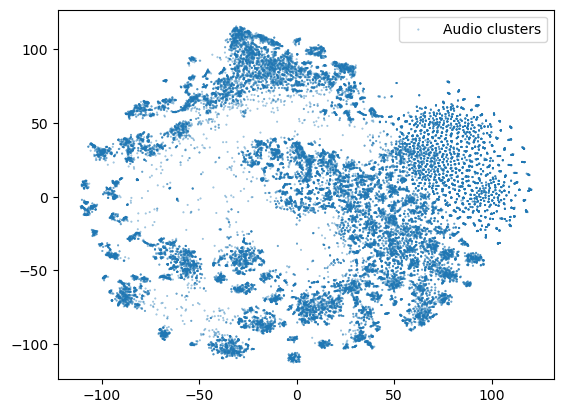

In [ ]:
plt.scatter(all_data_dimreduced[len(brain_data):, 0], all_data_dimreduced[len(brain_data):, 1], c=[cluster_colors[cluster] for cluster in audio_clusters], label="Audio clusters", alpha=0.5, s=0.2)
plt.legend()
plt.show()

### Visualizing all samples

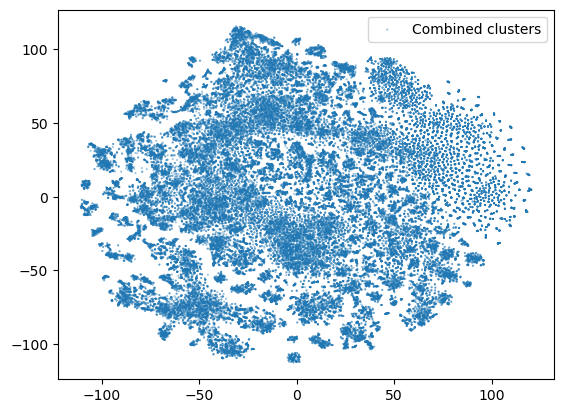

In [ ]:
plt.scatter(all_data_dimreduced[:, 0], all_data_dimreduced[:, 1], c=[cluster_colors[cluster] for cluster in brain_clusters] + [cluster_colors[cluster] for cluster in audio_clusters], label="Combined clusters", alpha=0.5, s=0.2)
plt.legend()
plt.show()